# Astrophysics Example: Simulate Planck Data

In [1]:
# This cells gives formatting to the images embedded in this Notebook
from IPython.core.display import HTML
HTML("""
<style>
img[alt=image] { width: 300px; }
</style>
""");

In this example we will work with observations of the Cosmic Microwave Background from the Planck satellite using advanced functionalities of `pandas` and `numpy` and we will create plots with `matplotlib`.

In section 1 we will read a map created by the Planck satellite and we will familiarize with HDF5 format and working with hierarchical indexing in `pandas`. We will also visualize sky maps in `matplotlib` using a curvilinear projection.

In section 2 we will use `numpy` to create a simulation of how Planck scans the sky thoughout a year of observations and we will plot scanning rings in different reference frames.

In section 3 we will use the scanning coordinates created in section 2 to simulate an observation of the map used in setion 1. We will add white noise and then learn how to use `pandas` groupby with hierarchical index to aggregate the data into a sky map. We will finally compare the simulated noisy map with the original map and study its features.

## The Planck satellite

[Planck](http://www.esa.int/Our_Activities/Space_Science/Planck_overview) is a Space Mission by the European Space Agency in collaboration with NASA. Its purpose is to measure the Cosmic Microwave Background; the relic radiation, originated just 300,000 years after the Big Bang, is a pillar in understanding how the Universe was born and how it evolved into its current state.

In this Notebook we will create a simulation of the Planck data using advanced functionalities of `pandas`.
![image](http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2009/03/planck_being_prepared_for_tests/9836424-3-eng-GB/Planck_being_prepared_for_tests.jpg)

In [2]:
import pandas as pd

## 1) Load and visualize a map created by the Planck satellite

The Planck satellite has several frequency channels between 30 GHz and 857 GHz, let's choose one of the middle channels which are the cleanest channels to investigate the Cosmic Microwave Background: 70 GHz.

I prepared a dataset from the official Planck 70 GHz map located at <http://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/>, you can download it from **TODO** figshare address

Let's use `!` to execute a shell command (`ls`) in the current folder to check that the file is available:

In [3]:
!ls planck*

planck_70GHz_map.hdf5


### 1.1) HDF5

[`HDF5`](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a binary file format extremely efficient in storing scientific data. It is very convenient because it stores also metadata about the file content and can have a hierarchical structure. It is currently the more efficient general purpose file format in terms of space (it supports several compression algorithms) and reading speed (it also supports parallel access on Supercomputers).

The first advanced `pandas` feature is reading and writing `pd.Series` and `pd.DataFrames` to `HDF5` with `read_hdf` and `to_hdf`.

Let's read the map from `HDF5` into a `pandas` object:

In [4]:
planck_map = pd.read_hdf("planck_70GHz_map.hdf5")

The more portable way to save a `pd.DataFrame` to disk is `HDF5`, `pickle` is another binary format but does not always work the same way on different platforms, `CSV` is text-based so it is an option only for small datasets.

In [5]:
type(planck_map)

pandas.core.series.Series

It is a `pd.Series`, in fact it is only 1 column of data: **Temperature of the sky in Kelvin degrees**, let's inspect this object:

The length of the dataset is

In [6]:
len(planck_map)

64800

but how are those points organized?

`pandas` objected are organized with their `index`, which is a label attached to every data point.

In [7]:
type(planck_map.index)

pandas.core.indexes.multi.MultiIndex

In [8]:
planck_map.head()

latitude  longitude
-90       -180         0.000063
          -179         0.000063
          -178         0.000063
          -177         0.000063
          -176         0.000063
Name: temperature, dtype: float64

In [9]:
planck_map.tail()

latitude  longitude
90        176          0.000026
          177          0.000026
          178          0.000026
          179          0.000026
          180         -0.000038
Name: temperature, dtype: float64

Each element in the dataset is a temperature of the sky in the direction given by the latitude and longitude stored in the Index.
Latitude is from -90 degrees below the Galactic plane to 90 degrees above the Galactic plane in steps of 1 degree, pretty much like the North and South Poles on Earth.
For each Latitude point, Longitude spans from -180 degrees to 180 degrees in steps of 1 degrees.

### 1.2) Hierarchical indexing

The second advanced feature of `pandas` is `pd.MultiIndex`, it is a way to setup a hierarchical indexing, in this case we have a rectangular grid of latitudes and longitudes with sizes:

In [10]:
list(zip(planck_map.index.names, planck_map.index.levshape))

[('latitude', 180), ('longitude', 360)]

in Galactic coordinates (latitude 0 is the Galactic Plane). For each value of latitude, for example 15 degrees above the Galactic plane, we have longitudes running from -180 to 180 degrees:

In [11]:
planck_map.loc[15]

longitude
-180    0.000182
-179    0.000111
-178    0.000080
-177    0.000078
-176    0.000099
          ...   
 176    0.000354
 177    0.000211
 178    0.000003
 179    0.000083
 180    0.000182
Name: temperature, Length: 360, dtype: float64

#### 1.2.1) MultiIndex example

Let's build a simpler example to play with a `pd.Series` with `pd.MultiIndex`, here we start from a list of tuples where we spell out all combinations of the 2 levels of our index:

In [12]:
sample_multiindex = pd.MultiIndex.from_tuples([("A", 1), ("A", 2), ("A", 3), ("B", 2), ("B", 3)], names=["letters", "numbers"])

Now we create a simple dataset with integers between 100 and 105 with this index:

In [13]:
sample_series_with_multiindex = pd.Series(list(range(100, 105)),index=sample_multiindex)

In [14]:
sample_series_with_multiindex

letters  numbers
A        1          100
         2          101
         3          102
B        2          103
         3          104
dtype: int64

If we want to select a data point, we need to specify a value for both levels of the index:

In [15]:
sample_series_with_multiindex[("B", 2)]

103

We can use the levels for grouping purposes:

In [16]:
sample_series_with_multiindex.groupby(level="letters").max()

letters
A    102
B    104
dtype: int64

In [17]:
sample_series_with_multiindex.groupby(level="numbers").max()

numbers
1    100
2    103
3    104
dtype: int64

### 1.3) Plot slices of the dataset

In this section we will plot some slices of the data in Longitude and Latitude.

First we call the `%matplotlib inline` magic function of Jupyter to set the plots to be displayed inside the Notebook.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

Then we can use `.loc` to extract a part of the data based on the value of the Index, in the case of a `MultiIndex`, if we provide only 1 value, that means the higher level of the Index, i.e. Latitude.

The following plot shows the emission 2 degrees above the Galactic Plane, we can easily identify extremely bright sources in the Microwave regime sitting close to the plane:

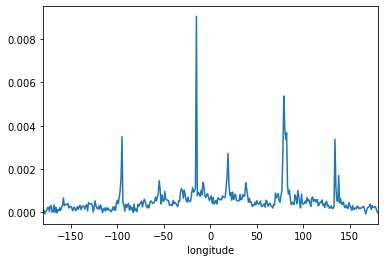

In [21]:
planck_map.loc[2].plot()

We can also overplot the emission at increasing Latitudes to check how the strong emission of the Galaxy fades away at higher latitudes:

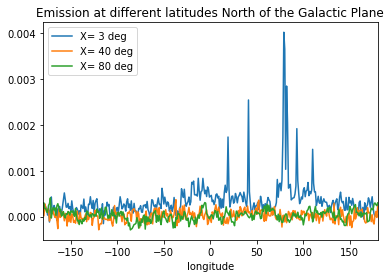

In [22]:
for lat in [3, 40, 80]:
    planck_map.loc[lat].plot(label="X= {} deg".format(lat))
plt.title("Emission at different latitudes North of the Galactic Plane")
plt.legend();

Using the same syntax we can instead plot a slice at a fixed Longitude, for example 1 degree and we can clearly identify the Galactic plane around Latitude 0.

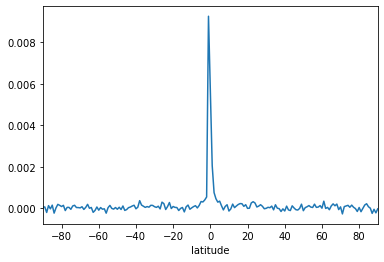

In [23]:
planck_map.loc[:, 1].plot();

### 1.4) Plot a map of the sky



One dimensional line plots are easy, just call the `.plot` function of any `pd.Series`, what we would like to achieve in this section is to plot the entire sky.

#### 1.4.1) Unstacking

The third advanced `pandas` feature is unstacking. It is the operation of transforming a dataset with a `pd.MultiIndex` into a 2 dimensional array.
Easier to look at it in action:

In [24]:
map_2d = planck_map.unstack()

In [25]:
type(map_2d)

pandas.core.frame.DataFrame

In [26]:
map_2d.columns

Int64Index([-180, -179, -178, -177, -176, -175, -174, -173, -172, -171,
            ...
             171,  172,  173,  174,  175,  176,  177,  178,  179,  180],
           dtype='int64', name='longitude', length=360)

In [27]:
map_2d.head()

longitude,-180,-179,-178,-177,-176,-175,-174,-173,-172,-171,...,171,172,173,174,175,176,177,178,179,180
latitude,,,,,,,,,,,,,,,,,,,,,
-90,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,...,1.238379e-04,0.000124,0.000124,0.000124,0.000124,0.000124,1.238379e-04,0.000124,0.000124,0.000063
-89,-0.000219,-0.000124,-0.000124,-0.000124,-0.000124,-0.000182,-0.000182,-0.000182,-0.000182,-0.000059,...,-1.856506e-04,-0.000058,-0.000058,-0.000058,-0.000058,-0.000157,-1.573854e-04,-0.000157,-0.000157,-0.000219
-88,-0.000195,-0.000197,-0.000197,-0.000180,-0.000180,-0.000187,-0.000187,-0.000031,-0.000031,-0.000151,...,-2.182215e-04,-0.000271,-0.000271,-0.000182,-0.000182,-0.000317,-3.167214e-04,-0.000300,-0.000300,-0.000195
-87,-0.000153,-0.000168,-0.000124,-0.000310,-0.000310,-0.000181,-0.000041,-0.000124,-0.000124,-0.000094,...,-5.043610e-07,-0.000067,-0.000067,-0.000141,-0.000148,-0.000155,-1.547419e-04,-0.000245,-0.000123,-0.000153
-86,0.000150,0.000160,0.000166,0.000011,0.000129,0.000115,0.000146,0.000033,0.000134,0.000097,...,2.905639e-05,0.000109,0.000148,-0.000060,0.000052,-0.000086,-8.843734e-07,0.000151,0.000016,0.000150


The unstacking operation is keeping the higher level of the `pd.MultiIndex`, Latitude, as the index and it is transforming the inner level of the index into Columns, therefore the output is a `pd.DataFrame` with 180 rows and 360 columns.

In [28]:
map_2d.shape

(180, 360)

Therefore we have transformed the initial dataset that was stored in a dimensional object into a 2 dimensional representation.

This is exactly what we need to plot it.
As a first step, we can just plot the 2d array as it is with `imshow`, which uses a colorscale to plot a 2d array based on the amplitude at each point.
We just need to set a minimum and maximum extreme of the scale with `vmin` and `vmax`, +-1 milliKelvin range, 1/1000 K is good for our purposes:

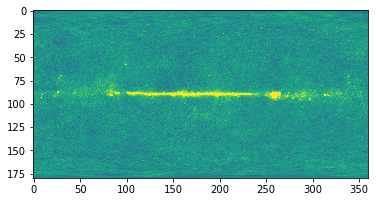

In [37]:
plt.imshow(map_2d, vmin=-1e-3, vmax=1e-3);

The plot shows latitude vertically and longitude horizontally, we can identify the galactic plane emission at the center of the map, most of the rest of the map shows the fluctuations of the Cosmic Microwave Background and some residual noise.

Below is a map from the European Space Agency with **only** the Cosmic Microwave Background (CMB) detected by Planck by combining all the different frequencies together and separating out the Galactic emission to help your eyes look for similar patterns in the data above:

![image](http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2013/03/planck_cmb/12583930-4-eng-GB/Planck_CMB.jpg)

The representation of a full sky map as a rectangle is quite misleading, we are displaying temperatures of data in a sphere, similar to maps of the Earth.

Cosmologists like to use the `Mollweide` projection because it preseres the area, which is one of the most important things when studing the CMB. The above map of the CMB by Planck is in Mollweide projection. See for example a [map of the Earth in Mollweide projection on Wikipedia](https://en.wikipedia.org/wiki/Mollweide_projection#/media/File:Mollweide_projection_SW.jpg).

Let's also plot our map the Cosmology way, first we extract Longitude and Latitude from the index:

In [38]:
latitude, longitude = planck_map.index.levels

In [39]:
longitude

Int64Index([-180, -179, -178, -177, -176, -175, -174, -173, -172, -171,
            ...
             171,  172,  173,  174,  175,  176,  177,  178,  179,  180],
           dtype='int64', name='longitude', length=360)

`matplotlib` supports Mollweide projection natively, we just need the more advanced `pcolormesh` plotting function, which has a similar functionality to `imshow`, but also requires `x` and `y` coordinates in radians. For this reason we import `numpy` to use the `np.radians` function to convert degrees to radians.

**Note**: the convention used here to plot maps is the _Geo_ convention, i.e. Longitude increasing East, in Astrophysics is actually more common to use the _Astro_ convention,i.e. Longitude increasing West. Maps in these 2 formats are flipped left-right. 

In [40]:
import numpy as np

In [41]:
def plot_mollweide_map(longitude, latitude, gridded_map, vmin=-1e-3, vmax=1e-3):
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(111, projection="mollweide")
    plt.pcolormesh(np.radians(longitude), np.radians(latitude), gridded_map, vmin=vmin, vmax=vmax);

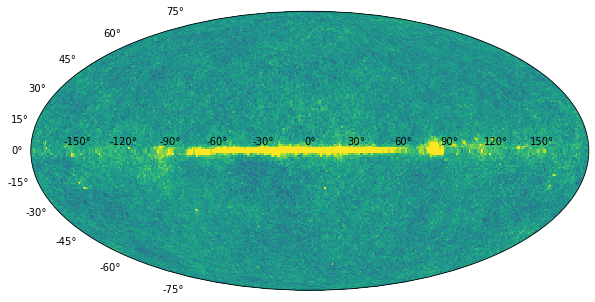

In [42]:
plot_mollweide_map(longitude, latitude, map_2d)

Finally we got a figure showing the full map we read from disk at the beginning of this example.

This map is a measurement of the brightness of the sky in the microwave regime looking in every direction around Earth, this data has been acquired by the Planck Satellite in over 4 years completing one full sky coverage every six months and then averaging all the data in a single map of the sky.

### 1.5) Masking the Galaxy

#### 1.5.1) Working with missing data

Very often analysis of the Cosmic Microwave Background requires masking of the Galaxy and other bright sources to avoid them contaminating the statistical properties of the rest of the sky.

There are mainly 2 strategies for quick&dirty masking, either a blind cut of data at low latitude or a cut based on the amplitude of the signal, let's try both on our map using `pandas`.

First we create a copy of the map and then slice the data in latitude and set the conventional symbol for missing data that is `np.nan` which stands for Not A Number.

`pandas` has several functionalities related to missing data, see [the documentation](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

In [43]:
galactic_cut_planck_map = planck_map.copy()

In [44]:
galactic_cut_planck_map.loc[-20:20,:] = np.nan

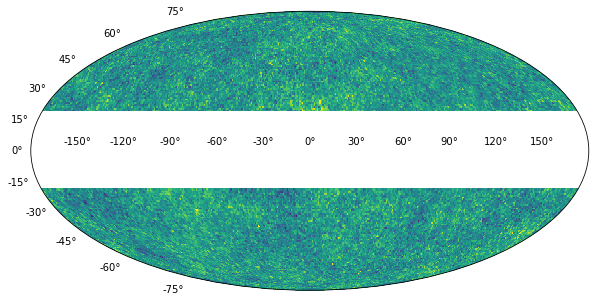

In [45]:
plot_mollweide_map(longitude,latitude,galactic_cut_planck_map.unstack(),vmin=-5e-4,vmax=5e-4)

A galactic cut is simple but not sophisticated enough, it masks a lot of low signal regions and leaves extragalactic sources and high latitude features of the Milky Way unmasked.

Let's try with a brightness cut instead, here we choose to mask all the points above a predefined threshold, we can tailor the threshold based on our knowledge of galactic emission.

See below how the syntax is very similar to pure `numpy` and creates a masked map that also covers sources outside of the galactic plane.

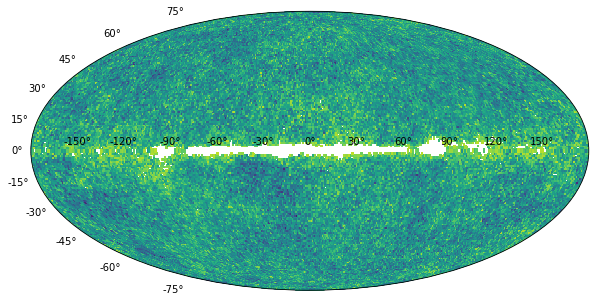

In [46]:
brightness_cut_planck_map = planck_map.copy()
brightness_cut_planck_map[brightness_cut_planck_map>.0004] = np.nan
plot_mollweide_map(longitude,latitude,brightness_cut_planck_map.unstack(),vmin=-5e-4,vmax=5e-4)

## 2) Simulate how Planck scans the sky

In the section about plotting the Planck map, we mentioned that the data was acquired over 4 years, but how exactly is Planck scanning the sky?

In this section we will simulate how Planck points its telescope thoughout one year.

### 2.1) The Planck orbit

Planck orbited the Lagrangian Point 2, which is an unstable equilibrium point in the Earth-Sun joint gravitational field. See in the figure below, this point is located 1.5 Million Km far from Earth on the continuation of the Sun-Earth axis. A satellite can be stationary around that point with minimal orbital manouvres, it **does not** orbit around Earth, it follows Earth in its trajectory around the Sun. This location is ideal for Astrophysics:

* it allows a very clean field of view, i.e. Sun, Earth and Moon contaminate only a small part of the sky
* thermal conditions are very stable because it is always at a similar distance from the Sun
* minimizes interference between communications antennas pointed to Earth and scientific instruments, pointed to Deep Space

![image](orbit_scan_by_smoot_group.png)

### 2.2) Motion of the Planck spin axis

The Planck spin axis is pointed along the Earth-Sun axis, so that the solar panels, located at the bottom of the spacecraft, are pointed to the Sun and the telescope, which is pointed 85 degrees from the spin axis, can scan sky circles at 1 rotation per minute.

See Youtube video below:

In [47]:
from IPython.display import YouTubeVideo

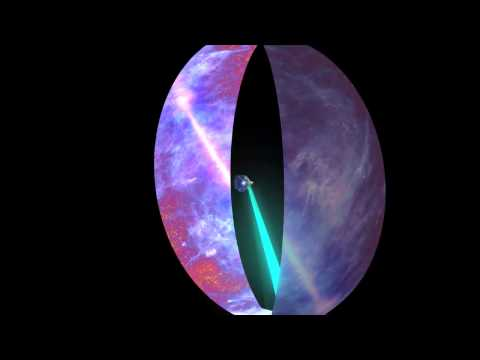

In [48]:
YouTubeVideo("lwELia_RAn0")

The Planck spin axis lays in the plane of the Solar System, the Ecliptic Plane.
We can simplify the math a little bit by assuming that the orbit of the Earth around the Sun takes 360 days, so that it spans exactly 1 degree per day.

Therefore we can refer to the Ecliptic Reference Frame, where 0 latitude is the Ecliptic Plane (as opposed to the Galactic Plane for Galactic coordinates) and describe the motion of the Earth as the Ecliptic Longitude between 0 and 360 degrees: 

In [49]:
spin_axis_longitude_ecliptic = np.arange(0, 360)

In [50]:
spin_axis_longitude_ecliptic[:5]

array([0, 1, 2, 3, 4])

In [51]:
n_points_eclipctic = len(spin_axis_longitude_ecliptic)

The Planck map is in Galactic Coordinates, so we have to learn how to convert Ecliptic to Galactic, the easiest way is to use the rotation matrix.

This rotation matrix transforms a vector from one reference frame to another, so we have to transform our coordinates from angles into vectors.

In [52]:
ecliptic_to_galactic_rotation_matrix = np.array([  [-0.054882486, -0.993821033, -0.096476249],
                                                   [ 0.494116468, -0.110993846,  0.862281440],
                                                   [-0.867661702, -0.000346354,  0.497154957]  ])

Ecliptic latitude is zero, so conversion is pretty straightforward:

In [53]:
spin_axis_vector_ecliptic = np.zeros([3, n_points_eclipctic])
spin_axis_vector_ecliptic[0, :] = np.cos(np.radians(spin_axis_longitude_ecliptic))
spin_axis_vector_ecliptic[1, :] = np.sin(np.radians(spin_axis_longitude_ecliptic))

Each column here is one coordinate in vector format, so the first is [1,0,0] which is pointing to the x axis (zero longitude) and then slowly moving away in the direction of the `y` axis. `z` is the vertical axis and is zero, being the latitude.

In [54]:
spin_axis_vector_ecliptic[:, :3]

array([[1.        , 0.9998477 , 0.99939083],
       [0.        , 0.01745241, 0.0348995 ],
       [0.        , 0.        , 0.        ]])

Some advanced `numpy` follows, `numpy` automatically figures out that we want to perform matrix vector multiplication of our 3x3 matrix with **each** of the 360 vectors in the array and computes it very efficiently, this is [broadcasting](https://docs.scipy.org/doc/numpy-1.10.1/user/basics.broadcasting.html), one of the most notable features of `numpy`:

In [55]:
spin_axis_vector_galactic = ecliptic_to_galactic_rotation_matrix.dot(spin_axis_vector_ecliptic)

In [56]:
spin_axis_vector_galactic[:, :3]

array([[-0.05488249, -0.0722187 , -0.08953291],
       [ 0.49411647,  0.4921041 ,  0.48994184],
       [-0.8676617 , -0.8675356 , -0.86714523]])

Finally we can transform back from vector coordinates to angles with some more trigonometry:

In [57]:
spin_axis_latitude_galactic = np.degrees(np.pi/2 - np.arccos(spin_axis_vector_galactic[2]) )
spin_axis_longitude_galactic = np.degrees(np.arctan2(spin_axis_vector_galactic[1], spin_axis_vector_galactic[0]))

We can use the Mollweide projection to have a feeling on how it would look like projected on the sky and even overlay the actual map of the sky.

In [58]:
def create_mollweide_axes():
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(111, projection="mollweide")
    return ax

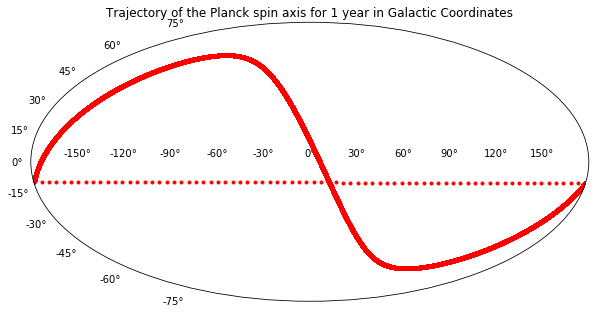

In [59]:
create_mollweide_axes()
plt.plot(np.radians(spin_axis_longitude_galactic), np.radians(spin_axis_latitude_galactic), '.', color="red")
plt.title("Trajectory of the Planck spin axis for 1 year in Galactic Coordinates");

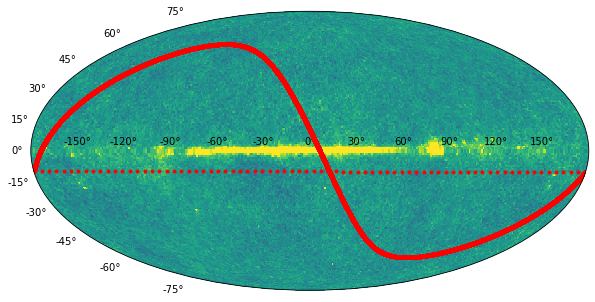

In [60]:
create_mollweide_axes()
plt.pcolormesh(np.radians(longitude), np.radians(latitude), map_2d, vmin=-1e-3, vmax=1e-3);
plt.plot(np.radians(spin_axis_longitude_galactic), np.radians(spin_axis_latitude_galactic), '.', color="red");

### 2.4) Motion of the field of view of the Planck telescope

As visualized in the Youtube video above, the Planck telescope is oriented 85 degrees of the spin axis and scans the sky at 1 revolution per minute, therefore we will use some more trigonometry and `numpy` to figure our the trajectory of the field of view of the scientific instruments aboard Planck.
To simplify the math, we will assume that the telescope is at 90 degrees.

We will refer to a scanning trajectory around the spin axis as a **ring** and we will assume that Planck for each day has a fixed spin axis and always scans the same ring, then the next day moves the spin axis 1 degree and scans the nearby ring. The real satellite has a similar scanning strategy but 1 ring only lasts about 40 minutes before a repointing manouvre of 1/30th of a degree.

In the spin axis trajectory we had 360 points, here we want to expand that and for each of those 360 points in Ecliptic we want to have a 360 degree scanning in Latitude (Latitude is -90 to 90 degrees, but a full meridian is twice that).
If we only choose 360 points in Latitude, once we convert to Galactic coordinates we can have a lot of pixels that are missed due to the different orientation of parallels and meridians in the two reference frames (try it yourself). Therefore better have a denser scanning of 3 points for each degree:

In [61]:
n_points_ring = 360*3

#### 2.4.1) numpy tile and repeat

Before digging into trigonometry, let's introduce 2 `numpy` functions that have similar functionality and are sometimes confused, `np.tile` repeats the entire array a number of times, instead `np.repeat` repeats each element a number of times. For example:

In [62]:
np.tile(np.arange(10), 4)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [63]:
np.repeat(np.arange(10), 4)

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9])

Back to the satellite scanning strategy, we first create again the spin axis LLongitude in ecliptic but we repeat each element `n_points_ring` times so we can accomodate the spinning in Latitude for each Longitude point.

In [64]:
spin_axis_longitude_ecliptic = np.repeat(np.linspace(0, 360, n_points_eclipctic), n_points_ring)

In [65]:
len(spin_axis_longitude_ecliptic)

388800

Then we create the Longitude array for the telescope by rotating the spin axis Longitude by +90 for half the points and for -90 for the other half.
For example if the spin axis is pointed at 30 degrees East, the telescope will be do a full Latitude scan of the meridian at 30 + 90 = 120 East and at 30 - 90 = 60 West.

In [66]:
telescope_longitude_ecliptic = spin_axis_longitude_ecliptic - \
    np.tile(
        np.concatenate([
            np.ones(n_points_ring//2)*90,
            -np.ones(n_points_ring//2)*90
        ]), n_points_eclipctic)
telescope_latitude_ecliptic = np.tile(
    np.linspace(-90, 90, n_points_ring//2), n_points_eclipctic*2
)

Below we can plot the first ring scanned in Ecliptic Coordinates, here the spin axis would be laying on the Ecliptic Plane, strat from 0 degrees and rotate all the way back to 0.
The telescope is oriented at 90 degrees, so it does a full 360 degrees scan, half on the meridian at 90 degrees East and the other half at 90 degrees West.

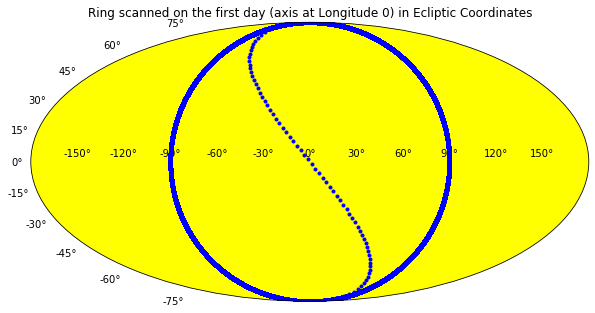

In [67]:
ax = create_mollweide_axes()
ax.set_facecolor('yellow') # Yellow stands for Ecliptic Coordinates
plt.plot(np.radians(telescope_longitude_ecliptic[:n_points_ring]),
         np.radians(telescope_latitude_ecliptic[:n_points_ring] ),
         '.', color="blue")
plt.title("Ring scanned on the first day (axis at Longitude 0) in Ecliptic Coordinates");

The conversion from angles to vectors is more complicated for a the general case, so see the function below that encapsulates this complexity. Code was extracted from the [`healpy` library](http://github.com/healpy/healpy).

This is a good example of a **reusable function**, it is important to write a good docstring, i.e. the multiline string that works as documentation for the code, and can probably be saved externally into a .py file and be imported in other notebooks.

In [68]:
def convert_angles_to_vec(lon, lat):
    """Convert Longitude and Latitude to vector representation
    
    Parameters
    ----------
    lon : np.array
        Longitude in degrees
    lat : np.array
        Latitude in degrees
        
    Returns
    -------
    vec : np.array (3, len(lon))
        First row is x, then y, z
    """
    theta,phi = np.pi/2.-np.radians(lat),np.radians(lon)
    ct,st,cp,sp = np.cos(theta),np.sin(theta),np.cos(phi),np.sin(phi)
    vec = np.empty((3, ct.size), np.float64)
    vec[0, :] = st * cp
    vec[1, :] = st * sp
    vec[2, :] = ct
    return vec

Finally we follow the same steps used for the spin axis and we get latitude and longitude inthe Galactic Reference Frame.

In [69]:
telescope_vec_ecliptic = convert_angles_to_vec(telescope_longitude_ecliptic, telescope_latitude_ecliptic)

In [70]:
telescope_vec_galactic = ecliptic_to_galactic_rotation_matrix.dot(telescope_vec_ecliptic)

In [71]:
telescope_vec_galactic

array([[ 0.09647625,  0.10226712,  0.10805452, ..., -0.10805452,
        -0.10226712, -0.09647625],
       [-0.86228144, -0.86161986, -0.86092901, ...,  0.86092901,
         0.86161986,  0.86228144],
       [-0.49715496, -0.49714449, -0.49711714, ...,  0.49711714,
         0.49714449,  0.49715496]])

In [72]:
telescope_latitude_galactic = np.degrees(np.pi/2 - np.arccos(telescope_vec_galactic[2]) )
telescope_longitude_galactic = np.degrees(np.arctan2(telescope_vec_galactic[1], telescope_vec_galactic[0]))

To check our result we can plot the spin axis position on the first day and the scanned ring on the same plot, we can check that when they cross they angle is about 90 degrees (consider that Mollweide projection distorts a bit the angles).

Therefore the Planck instrument in our simulation will be observing the ring of sky highlighted in blue for the first day, then reorient and observe the adjacent ring. With this scanning strategy, like the real satellite, it will take 6 months to cover the complete sky, that is because the spin axis will do just half rotation, but the telescope will cover both sides of the sky.

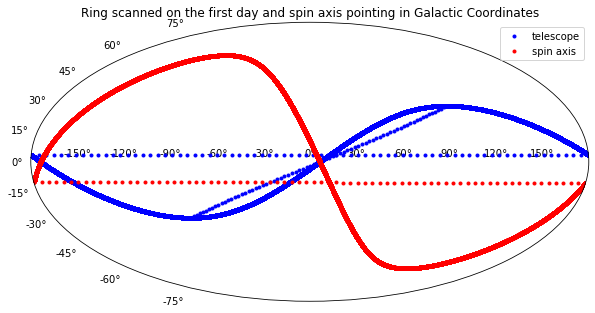

In [73]:
create_mollweide_axes()
plt.plot(
    np.radians(telescope_longitude_galactic[:n_points_ring]),
    np.radians(telescope_latitude_galactic[:n_points_ring] ), '.', color="blue", label="telescope")
plt.plot(
    np.radians(spin_axis_longitude_galactic[:n_points_ring]),
    np.radians(spin_axis_latitude_galactic[:n_points_ring] ), '.', color="red", label="spin axis")
plt.legend()
plt.title("Ring scanned on the first day and spin axis pointing in Galactic Coordinates");

#### 2.4.2) Variable number of arguments

Sometimes it is convenient to get a variable number of arguments in a function, the simpler way would be to just accept a list, however this would not be able to handle one single argument

In [74]:
def sum_many_list(numbers):
    result = 0
    for n in numbers:
        result += n
    return result

In [75]:
sum_many_list([5,2,7])

14

In [76]:
try:
    sum_many_list(3)
except Exception as e:
    print(type(e))
    print(e)

<class 'TypeError'>
'int' object is not iterable


A more elegant way to handle this is

`def your_function(*arguments):`

to accept either one or any number of arguments, for example:

In [77]:
def sum_many(*numbers):
    result = 0
    for n in numbers:
        result += n
    return result

In [78]:
sum_many(3)

3

In [79]:
sum_many(5,2,7)

14

The following function `create_scanning_ring` takes the number of day from the beginning of the mission, from 0 to 360, which also coincides with Ecliptic Longitude.

**Note**: this function is **not reusable**, see that it uses some external variables without getting them as arguments, for example `telescope_longitude_galactic`. This is common for creating a quick function in an interactive session, it is one of the features of Python that speeds up development. However we always have to remember that when we create a funciton to be saved for later use, it should take all the needed variables as arguments, so that the interface of the function is well defined, otherwise the behaviour of the function could change if some external variables change, which would make it unreliable.

In [80]:
def create_scanning_ring_figure(*days):
    create_mollweide_axes()
    for day in days:
        section = slice(n_points_ring*day, n_points_ring*(day+1))
        plt.plot(np.radians(telescope_longitude_galactic[section]),
                 np.radians(telescope_latitude_galactic[section]), '.')

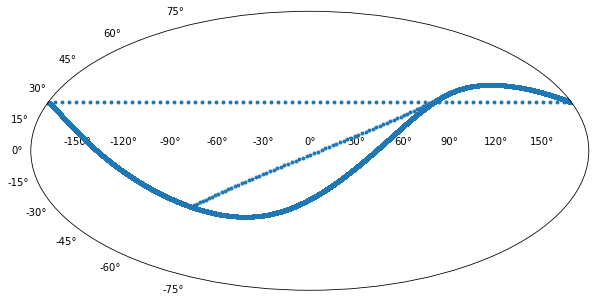

In [81]:
create_scanning_ring_figure(20)

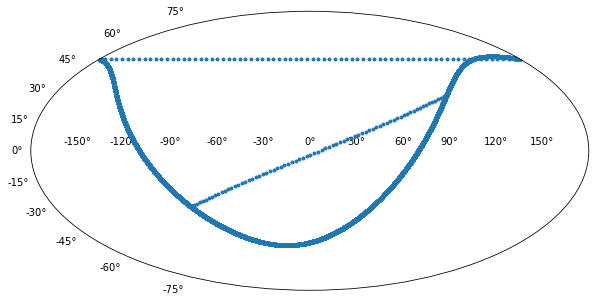

In [82]:
create_scanning_ring_figure(45)

In this section we achieved a description of the scanning of the telescope in Galactic coordinates for 1 year of the Planck Mission.

## 3) Create simulated data timelines

In the first section we loaded the sky emission data and understood its format, in the second section we created a simplified description of Planck's scanning strategy in Galactic coordinates. Now we can combine those two elements to create simulated data timelines.

It is common in Astrophysics, especially in fields like Cosmology where we study diffuse emission, to create maps of the sky subdivided in pixels and then index them with integers.

We can create a simple pixelated map by using the rectangular Latitude/Longitude grid described in the input Planck map, in `pandas` we can create a integer index by using `reset_index`, this is also going to turn the index into a column (two columns for our case of `MultiIndex`.

In [83]:
pixelated_map = planck_map.reset_index()

In [84]:
pixelated_map.index.name = "pixel"

In [85]:
pixelated_map.head()

,latitude,longitude,temperature
pixel,,,
0,-90,-180,0.000063
1,-90,-179,0.000063
2,-90,-178,0.000063
3,-90,-177,0.000063
4,-90,-176,0.000063


This allows us to refer very efficiently to a location in the sky just with an integer index.

Of course such simple scheme is not ideal on the sphere because we have the same number of pixels in Longitude both at the equator, where the length of parallels is the largest and near the poles, where the parallels are much shorter. We are therefore undersampling at the Equator and oversampling near the Poles. At the Poles this scheme is degenerate, i.e. any Longitude points to the same sky location.

For this reason the most common pixelization strategy in Cosmic Microwae Background is the [HEALPix](https://en.wikipedia.org/wiki/HEALPix) scheme, which has the property of equal area pixels everywhere.

### 3.1) Turn telescope coordinates into pixels

In [86]:
index_into_each_row = (telescope_longitude_galactic + 180).astype(np.int)

In [87]:
index_into_each_row.max()

359

In [88]:
column = (telescope_latitude_galactic+90).astype(np.int)

In [89]:
column.max()

179

In [90]:
telescope_pix_galactic = column * 360 + index_into_each_row

In [91]:
telescope_pix_galactic.min()

13

In [92]:
telescope_pix_galactic.max()

64799

### 3.2) Create data timelines

Planck started acquiring data on 13th August 2009, let's simplify the scenario by assuming it was pointing at exactly 0 degrees in Ecliptic Longitude.

Let's first create the index, also in this case we want a `MultiIndex`, but instead of it being Latitude and Longitude like `planck_map`, it will be `date` and `pixel`.
We can use `pd.MultiIndex.from_arrays` to create a `MultiIndex` from 2 arrays that give the value of both levels of the index.

In [93]:
date_range = pd.date_range('13/8/2009', periods=360, freq='D')

In [94]:
timelines_index = pd.MultiIndex.from_arrays([
    date_range.repeat(n_points_ring), telescope_pix_galactic
], names=["date","pixel"])

We can inspect more easily an index by creating a dummy series and printing out few values:

In [95]:
f = pd.Series(1, index=timelines_index)

In [96]:
f.tail()

date        pixel
2010-08-07  43117    1
            43117    1
            43117    1
            43116    1
            43116    1
dtype: int64

As we expect for each `date` we have all the pixels scanned during that day.
Then we can go ahead and create a simulated data of 1 year of Planck observations by using `reindex`.

#### 3.2.1) Reindexing with MultiIndex

Let's first take a look at the standard reindexing feature:

In [97]:
sample_map = pd.Series([105, 100, 108])

In [98]:
sample_map

0    105
1    100
2    108
dtype: int64

We created a sample map with only 3 pixels, labelled 0,1 and 2.

The we can define a scanning where we are observing pixel 2 for 3 times and then other pixels:

In [99]:
sample_scanning = pd.Index([2, 2, 2, 1, 0, 1])

We can then create a dataset that contains the measurements in 2 equivalent ways, either normal Python indexing or with `reindex`:

In [100]:
sample_map[sample_scanning]

2    108
2    108
2    108
1    100
0    105
1    100
dtype: int64

In [101]:
sample_map.reindex(sample_scanning)

2    108
2    108
2    108
1    100
0    105
1    100
dtype: int64

However if we have a `pd.MultiIndex` and we want to do reindexing on just one level leaving the other unchanged, we need to use `reindex` and specify a level explicitely.

In [102]:
sample_scanning_with_dates = pd.MultiIndex.from_arrays([
    pd.date_range("21/11/1999", periods=3, freq="D").repeat(2),
    sample_scanning
], names=["date","pixel"])

In [103]:
sample_scanning_with_dates

MultiIndex([('1999-11-21', 2),
            ('1999-11-21', 2),
            ('1999-11-22', 2),
            ('1999-11-22', 1),
            ('1999-11-23', 0),
            ('1999-11-23', 1)],
           names=['date', 'pixel'])

Direct indexing tries to use both levels of the `MultiIndex` but this won't work because `sample_map` only knows about pixels, not dates:

In [104]:
sample_map[sample_scanning_with_dates]

date        pixel
1999-11-21  2       NaN
            2       NaN
1999-11-22  2       NaN
            1       NaN
1999-11-23  0       NaN
            1       NaN
dtype: float64

In [105]:
sample_map.reindex(sample_scanning_with_dates, level="pixel")

date        pixel
1999-11-21  2        108
            2        108
1999-11-22  2        108
            1        100
1999-11-23  0        105
            1        100
dtype: int64

Using the same strategy we can create simulated timelines reindexing the map with the index composed by date and galactic pixel observed by the telescope:

In [106]:
simulated_timelines = pixelated_map.temperature.reindex(timelines_index, level="pixel")

In [107]:
simulated_timelines.head()

date        pixel
2009-08-13  21696    0.000137
            21696    0.000137
            21697    0.000121
            21697    0.000121
            21697    0.000121
Name: temperature, dtype: float64

In [108]:
len(simulated_timelines)

388800

### 3.3) Add white noise

Real data have noise due to the instrument electronics, for our simulation we can assume that the input map was noiseless and we can add some white noise to our simulated timelines, `np.random.normal` creates noise with a Gaussian distribution with an amplitude of 1 milliKelvin:

In [109]:
noise = np.random.normal(scale=.001, size=len(simulated_timelines))

We can add a `numpy` array to a `pd.Series`, this will create a new `pd.Series` summing the array to the `pd.Series` value, leaving the index unmodified:

In [110]:
simulated_noisy_timelines = simulated_timelines + noise

### 3.4) Create a sky map from timelines

What we have now are timelines functionally equivalent to the data that the Planck satellite streamed back to Earth. This dataset contains several observations of the same sky pixel on different days.
The mapmaking process identifies the data that point to the same pixels and averages them in order to reduce the impact of the noise in the data.

In `pandas` we can bin all the data by pixel using the `groupby` operation, here we want to group by a level of the index, so we specify the level keyword, then we call `.mean()` to average those data:

In [111]:
simulated_noisy_map = simulated_noisy_timelines.groupby(level="pixel").mean()

This is basically the opposite operation of the _scanning_ operation we performed before, here we start from a timeline as a function of date and pixel and aggregate the data in a single map of the sky.

However checking the lenght we notice that we have a lower number of pixels than the original `pixelated_map`, this is due to our rough pixelization scheme close to the poles.

In [112]:
len(simulated_noisy_map)

60548

In [113]:
len(pixelated_map)

64800

In [114]:
simulated_noisy_map.head()

pixel
13    0.000025
27    0.000801
39   -0.000575
56    0.000504
70   -0.000885
Name: temperature, dtype: float64

Finally we'd like to visualize this map and compare it to the original, but our plotting routine requires a complete 180x360 pixel map, so we have first to `reindex` our partial map of the sky to a full map. This will introduce `NaN` in missing pixels, see section

In [115]:
full_simulated_noisy_map = simulated_noisy_map.reindex(pixelated_map.index)

In [116]:
full_simulated_noisy_map.head()

pixel
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: temperature, dtype: float64

In [117]:
vmax = 3e-3
vmin = -3e-3

Let's first plot again the orignal map and compare it with the noisy map below:

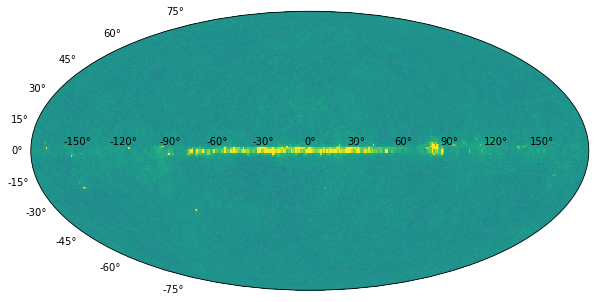

In [118]:
create_mollweide_axes()
plt.pcolormesh(np.radians(longitude), np.radians(latitude), pixelated_map.temperature.values.reshape((180,360)), vmin=vmin, vmax=vmax);

**Note**: no worries about the `RuntimeWarning`, it is due to the presence of `NaN` in the map.

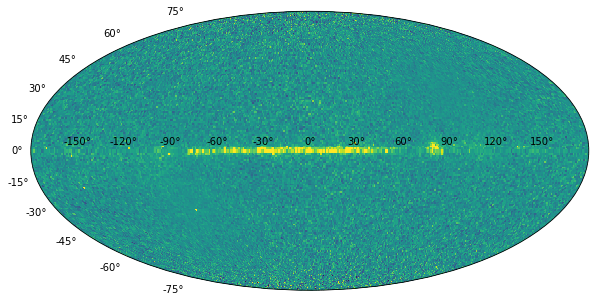

In [119]:
create_mollweide_axes()
plt.pcolormesh(np.radians(longitude), np.radians(latitude), full_simulated_noisy_map.values.reshape((180,360)), vmin=vmin, vmax=vmax);

We can also directly inspect the difference:

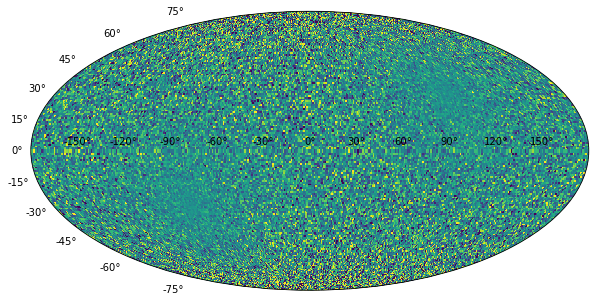

In [120]:
create_mollweide_axes()
plt.pcolormesh(np.radians(longitude), np.radians(latitude),
               (full_simulated_noisy_map - pixelated_map.temperature).values.reshape((180,360)), vmin=-1e-3, vmax=1e-3);

First of all we notice a lot more granularity all over the sky due to the noise. Also we see that near the Poles there are several darker missing pixels, as explained before.
Finally we can notice that 2 areas of the sky, one in the top-right and the other in the lower-left quadrant, show significantly less granularity. Those are the Ecliptic Poles, check the plot below of some rings, you can see that all of them cross at the Ecliptic Poles. Therefore there are lot more observations at the poles due to the Planck scanning strategy and the white noise is averaged down.

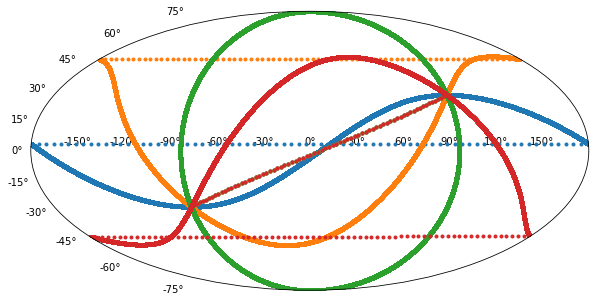

In [121]:
create_scanning_ring_figure(0, 45, 90, 135)

#### 3.4.1) Create a hit count map

Even better, we can create a hitcount map by using `count()` instead of `mean()` in the grouping by pixel operation:

In [122]:
full_hit_count_map = simulated_noisy_timelines.groupby(level="pixel").count().reindex(pixelated_map.index)

Checking the histogram we see that the variation of hits is very high, in linear scale it is difficult to visualize the differences, a logarithmic scale works better for this kind of data:

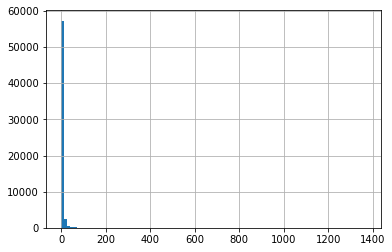

In [123]:
full_hit_count_map.hist(bins=100)

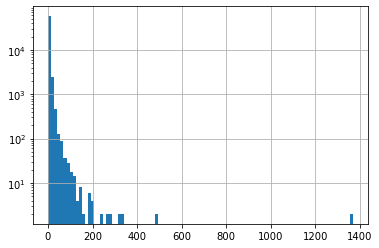

In [124]:
full_hit_count_map.hist(bins=100, log=True)

Therefore we can create a Mollweide map of the hits in logarithm in base 10:

/Users/altintas/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


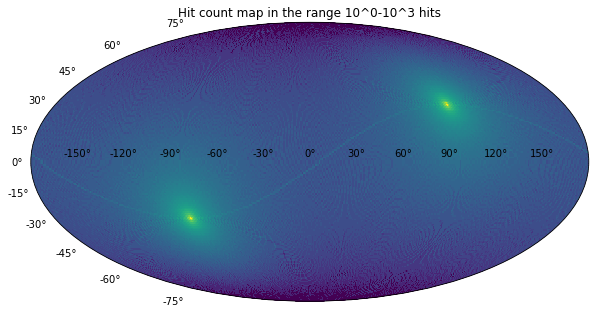

In [115]:
create_mollweide_axes()
plt.title("Hit count map in the range 10^0-10^3 hits")
plt.pcolormesh(np.radians(longitude), np.radians(latitude), np.log10(full_hit_count_map.values.reshape((180,360))),
               vmin=0, vmax=3);

### 3.5) Create a map of a data slice

We can also slice the timelines using `pandas` `.loc` to extract only the data for the first month and plot only that portion of the data. This is used a lot in null tests where we plot for example the first 2 years of data against the second 2 years of data to look for residual systematic effects.

In [116]:
simulated_noisy_timelines_first_month = simulated_noisy_timelines.loc[slice("14/8/2009", "13/9/2009")]

In [117]:
len(simulated_noisy_timelines_first_month)/360

93.0

In [118]:
simulated_noisy_map_first_month= simulated_noisy_timelines_first_month.groupby(level="pixel").mean()

/Users/altintas/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


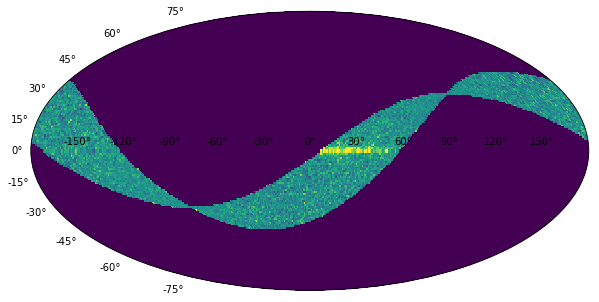

In [119]:
create_mollweide_axes()
vmax = 3e-3
vmin = -3e-3

plt.pcolormesh(np.radians(longitude), np.radians(latitude),
            simulated_noisy_map_first_month.reindex(pixelated_map.index).values.reshape((180,360)), vmin=vmin, vmax=vmax);

This concludes our Astrophysics example about Planck, check back througout the Notebook for links to additional resources and documentation.